In [1]:
# !pip install --upgrade mxnet==1.6.0
# !pip install gluonts
# !pip install prophet

In [2]:
# Import libraries
import os
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import r2_score
import os 
from datetime import datetime, timedelta
from datetime import timedelta

In [3]:
file = "traffic.txt"
isExist = os.path.exists(file)
if not isExist:
    print(f"Files not exist")

In [4]:
"""Preprocess data"""
data = pd.read_csv('traffic.txt', delimiter = ',', header=None)
print('data loaded..')
data_2 = data.copy()
#pick the first 20 clients
data_2 = data_2.iloc[:,:860]
#create time column: 2 years 1 hour
data_2['time'] = pd.to_datetime(np.arange(datetime(2015,1,1), datetime(2017,1,1), timedelta(hours=1)))
data_2.index = data_2['time']
data_2 = data_2.drop(['time'], axis = 1)
#create column names
data_3 = data_2.copy()
col_names = ['MT_{0:03}'.format(i+1) for i in range(data_3.shape[1])]
data_3.columns = col_names
aggregated_data = data_3.copy()

data loaded..


In [5]:
aggregated_data.shape

(17544, 860)

In [6]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
Std_normalization = 1
if Std_normalization:
    scaler = StandardScaler()
    temp = scaler.fit_transform(aggregated_data)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(aggregated_data)
global data_4
normalized_data = pd.DataFrame(temp, index=aggregated_data.index, columns = aggregated_data.columns)

In [7]:
normalized_data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_851,MT_852,MT_853,MT_854,MT_855,MT_856,MT_857,MT_858,MT_859,MT_860
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,-0.649143,-0.936348,-1.154807,-0.569033,-0.500971,-0.765328,-0.665566,-0.660995,-0.414196,...,-1.090083,-0.247300,-0.931665,-1.210117,-0.883220,-1.230655,-1.292127,-1.236952,-0.319897,-1.610681
2015-01-01 01:00:00,-0.674341,-0.645010,-0.862140,-1.067719,-0.513278,-0.488945,-0.701394,-0.490022,-0.447094,-0.407787,...,-1.161934,-0.151119,-1.042126,-1.323147,-0.725616,-1.324815,-1.398400,-1.326229,-0.269994,-1.674331
2015-01-01 02:00:00,-0.725568,-0.742124,-0.963111,-1.203794,-0.610849,-0.594173,-0.822705,-0.641794,-0.681695,-0.484698,...,-1.189306,-0.230327,-1.086310,-1.368359,-1.031272,-1.360686,-1.440910,-1.361940,-0.386435,-1.699791
2015-01-01 03:00:00,-0.727168,-0.826841,-1.022720,-1.296324,-0.666604,-0.672342,-0.886640,-0.810024,-0.959996,-0.602201,...,-1.182463,-0.345367,-1.064218,-1.345753,-1.145893,-1.351718,-1.419655,-1.344085,-0.580504,-1.687061
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,-0.573359,...,-1.117455,-0.428346,-0.946393,-1.225188,-1.184100,-1.266526,-1.306296,-1.248855,-0.735759,-1.619167


In [8]:
# Hyper-parameters
n_clients = 860
prediction_length = 24
freq = "1H"
train_start = pd.Period("01-01-2015", freq=freq) 
test_start = pd.Period("25-12-2016", freq=freq)
missing_percentage = 80

/home/tung6100/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3135: UserWarning: Parsing '25-12-2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [9]:
"""

Create missing values based on normal distribution random choice

Input: 
 - pd_data: 2d pandas data frame
 - missing_percentage: missing percentage <= 100

Output:
 - return_data: 2d pandas with missed values

"""
def create_missing_data(pd_data, missing_percentage = 20):
    if missing_percentage == 0: return pd_data
    assert missing_percentage <= 100, "missing percentage should be less than or equal 100%"
    np.random.seed(1993)
    # Convert data frame to array
    np_data = pd_data.to_numpy()
    # Convert original data to 1d array - Because existing package only supports to randomly choose indices from 1d array
    np_data_1d = np_data.flatten()
    # Randomly choose missing index
    total_elem = np_data_1d.shape[0]
    number_of_missing_elem = int(missing_percentage*1.0*total_elem/100)
    missing_index = np.random.choice(np.arange(total_elem), number_of_missing_elem, replace=False) # with replace = False, an index only is chosen 1 time
    # Replace missing_index with 0
    np_data_1d[missing_index] = 0
    # Convert 1d array to 2d array
    np_data_2d = np_data_1d.reshape(pd_data.shape[0], pd_data.shape[1])
    # Convert 2d array to dataframe
    cols_name = pd_data.columns
    return_data = pd.DataFrame(np_data_2d, columns = cols_name)
    return_data.index = pd_data.index
    return return_data

missing_df = create_missing_data(normalized_data, missing_percentage=20)
missing_df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_851,MT_852,MT_853,MT_854,MT_855,MT_856,MT_857,MT_858,MT_859,MT_860
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,-0.712761,0.000000,-0.936348,-1.154807,-0.569033,-0.500971,-0.765328,0.000000,-0.660995,-0.414196,...,0.000000,-0.247300,0.000000,-1.210117,-0.883220,-1.230655,0.000000,-1.236952,-0.319897,-1.610681
2015-01-01 01:00:00,-0.674341,0.000000,-0.862140,-1.067719,-0.513278,-0.488945,-0.701394,-0.490022,-0.447094,-0.407787,...,-1.161934,-0.151119,-1.042126,0.000000,-0.725616,-1.324815,-1.398400,-1.326229,-0.269994,0.000000
2015-01-01 02:00:00,-0.725568,-0.742124,0.000000,-1.203794,-0.610849,-0.594173,0.000000,0.000000,-0.681695,-0.484698,...,0.000000,-0.230327,0.000000,-1.368359,0.000000,-1.360686,0.000000,-1.361940,-0.386435,-1.699791
2015-01-01 03:00:00,-0.727168,0.000000,-1.022720,-1.296324,-0.666604,-0.672342,-0.886640,-0.810024,-0.959996,-0.602201,...,-1.182463,-0.345367,-1.064218,-1.345753,-1.145893,-1.351718,-1.419655,0.000000,-0.580504,-1.687061
2015-01-01 04:00:00,-0.722366,-0.837172,-1.055566,-1.318096,-0.680543,-0.706917,-0.925984,-0.948996,-1.114097,0.000000,...,-1.117455,-0.428346,0.000000,-1.225188,-1.184100,-1.266526,-1.306296,0.000000,-0.735759,0.000000


In [10]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:17376,:n_clients] 
    data_test = normalized_data.iloc[17376:,:n_clients]
    return data_train, data_test

In [11]:
data_train, data_test = set_train_test(n_clients=860)
print(data_train.shape)
print(data_test.shape)

(17376, 860)
(168, 860)


In [12]:
data_test.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_851,MT_852,MT_853,MT_854,MT_855,MT_856,MT_857,MT_858,MT_859,MT_860
time,,,,,,,,,,,,,,,,,,,,,
2016-12-25 00:00:00,-0.707958,-0.694600,-0.985008,-1.127592,-0.549519,-0.589663,-0.760410,-0.680195,-0.727695,-0.549859,...,-0.635028,-0.462292,-0.438273,-0.569615,-1.236635,-1.073722,-1.022900,-0.683431,-0.253360,-0.367379
2016-12-25 01:00:00,-0.711160,-0.723528,-1.010555,-1.241894,-0.594123,-0.664826,-0.825984,-0.786252,-0.902496,-0.659884,...,-0.768465,-0.609392,-0.534006,-0.697716,-1.236635,-1.158914,-1.065410,-0.951263,-0.441883,-0.511653
2016-12-25 02:00:00,-0.723967,-0.835106,-1.115175,-1.367083,-0.663816,-0.708421,-0.588279,-0.965453,-1.107197,-0.676976,...,-0.932696,-0.794210,-0.585554,-0.810745,-1.236635,-1.315848,-1.136259,-1.171481,-0.613773,-0.655927
2016-12-25 03:00:00,-0.723967,-0.868166,-1.169918,-1.413348,-0.700057,-0.727963,-0.932541,-1.091625,-1.415398,-0.618224,...,-1.052447,-0.833814,-0.637103,-0.878563,-1.236635,-1.423459,-1.164598,-1.367892,-0.752393,-0.778984
2016-12-25 04:00:00,-0.727168,-0.868166,-1.176001,-1.337147,-0.697269,-0.729466,-0.580082,-1.108082,-1.445298,-0.640656,...,-1.100348,-0.833814,-0.644467,-0.871028,-1.236635,-1.369653,-1.178768,-1.427410,-0.813387,-0.829904


In [13]:
"""Function to split train and test dataset"""
def set_train_test(n_clients=20):
    data_train = normalized_data.iloc[:17376,:n_clients] #25600; 25968; 26082
    data_test = normalized_data.iloc[17376:17376+prediction_length,:n_clients]
    data_test_deepAR = normalized_data.iloc[:17376+prediction_length,:n_clients]
    return data_train, data_test, data_test_deepAR

In [14]:
"""Check train and test dataset"""
data_train, data_test, data_test_deepAR = set_train_test(n_clients=860)
data_train.shape, data_test.shape, data_test_deepAR.shape

((17376, 860), (24, 860), (17400, 860))

In [15]:
missing_percentage

80

In [16]:
data_train_missing_vals = create_missing_data(data_train, missing_percentage=missing_percentage)
data_train_missing_vals.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_851,MT_852,MT_853,MT_854,MT_855,MT_856,MT_857,MT_858,MT_859,MT_860
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.000000,0.000000,0.000000,-1.154807,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,-1.236952,-0.319897,0.0
2015-01-01 01:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,-0.488945,0.00000,-0.490022,-0.447094,0.000000,...,-1.161934,0.0,0.0,0.000000,-0.725616,0.0,0.000000,0.000000,0.000000,0.0
2015-01-01 02:00:00,-0.725568,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-0.484698,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,-0.386435,0.0
2015-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.88664,0.000000,-0.959996,-0.602201,...,0.000000,0.0,0.0,-1.345753,0.000000,0.0,0.000000,0.000000,-0.580504,0.0
2015-01-01 04:00:00,0.000000,-0.837172,-1.055566,0.000000,-0.680543,0.000000,0.00000,-0.948996,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,-1.306296,0.000000,0.000000,0.0


In [17]:
data_train_missing_vals.iloc[:, :n_clients].to_numpy().shape

(17376, 860)

In [18]:
"""Convert data to numpy"""
data_train_np = data_train_missing_vals.iloc[:, :n_clients].to_numpy()
data_test_np = data_test.iloc[:, :n_clients].to_numpy()
data_test_deepAR_np = data_test_deepAR.iloc[:, :n_clients].to_numpy()
data_train_np = data_train_np.T
data_test_np = data_test_np.T
data_test_deepAR_np = data_test_deepAR_np.T
# Check the type of data
type(data_train_np), data_train_np.shape, data_test_np.shape, data_test_deepAR_np.shape

(numpy.ndarray, (860, 17376), (860, 24), (860, 17400))

In [19]:
"""Create dataset for Gluont"""
from gluonts.dataset.common import ListDataset
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset(
    [{"target": x, "start": train_start} for x in data_train_np],
    freq=freq,
)
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset(
    [{"target": x, "start": train_start} for x in data_test_deepAR_np], freq=freq
)

In [20]:
from gluonts.model.prophet import ProphetPredictor
from gluonts.mx import Trainer

Importing plotly failed. Interactive plots will not work.


In [21]:
estimator = ProphetPredictor(prediction_length=prediction_length,)

In [22]:
predictor = estimator.predict(train_ds, num_samples=1)

In [23]:
predictions = list(predictor)
predictions[0].samples

15:25:11 - cmdstanpy - INFO - Chain [1] start processing
15:25:15 - cmdstanpy - INFO - Chain [1] done processing
15:25:15 - cmdstanpy - INFO - Chain [1] start processing
15:25:18 - cmdstanpy - INFO - Chain [1] done processing
15:25:19 - cmdstanpy - INFO - Chain [1] start processing
15:25:21 - cmdstanpy - INFO - Chain [1] done processing
15:25:21 - cmdstanpy - INFO - Chain [1] start processing
15:25:26 - cmdstanpy - INFO - Chain [1] done processing
15:25:26 - cmdstanpy - INFO - Chain [1] start processing
15:25:29 - cmdstanpy - INFO - Chain [1] done processing
15:25:30 - cmdstanpy - INFO - Chain [1] start processing
15:25:31 - cmdstanpy - INFO - Chain [1] done processing
15:25:31 - cmdstanpy - INFO - Chain [1] start processing
15:25:34 - cmdstanpy - INFO - Chain [1] done processing
15:25:34 - cmdstanpy - INFO - Chain [1] start processing
15:25:37 - cmdstanpy - INFO - Chain [1] done processing
15:25:37 - cmdstanpy - INFO - Chain [1] start processing
15:25:40 - cmdstanpy - INFO - Chain [1]

array([[-0.35923551, -0.17394628,  0.35884593, -0.87368509, -0.07588434,
        -0.39222483,  0.88529172,  0.24384967, -0.19477362,  0.1602201 ,
        -0.37801024, -0.151641  , -0.61838353, -0.01456524,  0.59503373,
         0.1595133 ,  0.15621957, -0.22257781,  0.2373622 , -0.09619137,
         0.04720731, -0.80576522, -0.65812851, -0.32460018]])

In [25]:
# Convert gluont package into a numerical list
predictions_list = []
for prediction in predictions:
  predictions_list.append(prediction.samples)
predictions_np = np.array(predictions_list)
predictions_np = predictions_np.reshape(n_clients, 24)
predictions_np.shape

(860, 24)

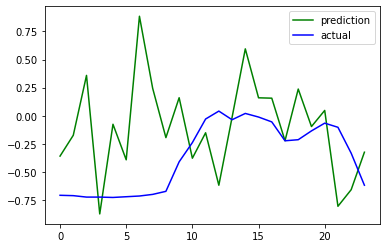

In [26]:
# Check prophet results
import matplotlib.pyplot as plt

prediction_0 = predictions_np[0]
actual_0 = data_test_np[0, :24]

plt.plot(prediction_0, color='g', label="prediction")
plt.plot(actual_0, color='b', label="actual")
plt.legend()
plt.show()

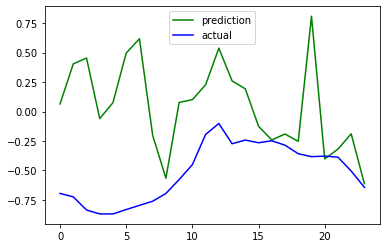

In [27]:
import matplotlib.pyplot as plt

prediction_1 = predictions_np[1]
actual_1 = data_test_np[1, :24]

plt.plot(prediction_1, color='g', label="prediction")
plt.plot(actual_1, color='b', label="actual")
plt.legend()
plt.show()

In [28]:
# Calculate RMSE
actual_data = data_test_np[:, :24]
rmse = np.sqrt(np.mean(np.square(actual_data - predictions_np)))
rmse

0.8351639635123134

In [29]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
def evaluate_Testset(y_true, y_pred):
    def mape(y_true, y_pred): 
      return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    MSE = mse(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mae(y_true, y_pred)
    MAPE = mape(y_true, y_pred)
    return MSE, RMSE, MAE, MAPE

# Function to estimate accuracy for one user
def accuracy_Testset(y_true, y_pred):
  diff_pred = list()
  diff_true = list()
  accuracy = 0.
  for i in range(len(y_true)-1):
      diff_pred.append(y_pred[i+1]-y_pred[i])
      diff_true.append(y_true[i+1]-y_true[i])
  count = sum(diff_pred[i] * diff_true[i] > 0 for i in range(len(diff_pred)))
  accuracy = count/len(diff_pred) * 100
  return accuracy

# Function to estimate average accuracy for multiple users
def average_acc(y_true, y_pred):
    n_users = y_true.shape[0]
    acc_list = []
    for i in range(n_users):
        y_true_i = y_true[i]
        y_pred_i = y_pred[i]
        acc = accuracy_Testset(y_true_i, y_pred_i)
        acc_list.append(acc)
    acc_np = np.array(acc_list)
    # print(acc_np)
    avg_acc = np.mean(acc_np)
    return avg_acc

In [30]:
MSE, RMSE, MAE, MAPE = evaluate_Testset(actual_data, predictions_np)
avg_acc = average_acc(actual_data, predictions_np)
print(f"MSE: {MSE}, RMSE: {RMSE}, MAE: {MAE}, MAPE: {MAPE}")
print(f"Avg_Acc: {avg_acc}")

MSE: 0.6974988459495965, RMSE: 0.8351639635123133, MAE: 0.672042376355503, MAPE: 638.7884806219313
Avg_Acc: 46.96663296258848
